In [72]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from tqdm import tqdm

# specify GPU
device = torch.device("cuda")

In [73]:
df = pd.read_csv("data/spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [74]:
df['label'].value_counts(normalize=True)

0    0.865937
1    0.134063
Name: label, dtype: float64

In [75]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=40, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=40, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import Bert - base- uncased

In [76]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [77]:
seq_len = [len(i.split()) for i in train_text]
# seq_len

<Axes: >

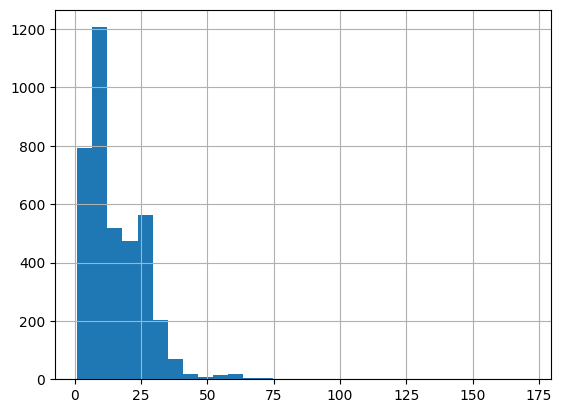

In [78]:
pd.Series(seq_len).hist(bins = 30)

# Tokenize & Encode the Sequences

In [79]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length =  25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length=25,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/home/kazi/Works/Projects/nlp-deep/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2285: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [80]:
# tokens_train

In [81]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [82]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Model Architecture

In [83]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [84]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        
        self.bert = bert 
        
        # dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)
      
        # apply softmax activation
        x = self.softmax(x)

        return x

In [85]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [86]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),lr = 1e-5) 

/home/kazi/Works/Projects/nlp-deep/venv/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [87]:
from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)

print("Class Weights:", class_weights)

Class Weights: [0.57743559 3.72848948]


In [88]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [89]:
def train(model, train_dataloader, optimizer, device='cpu'):
    """
    Train the model on the training set.
    
    Parameters:
    model -- PyTorch model to be trained
    train_dataloader -- DataLoader for the training set
    optimizer -- optimizer for updating model parameters
    device -- device on which to perform training (CPU or GPU)
    
    Returns:
    avg_loss -- average loss on the training set
    total_preds -- model predictions
    """
    try:
        # Ensure the device is available
        if device == 'cuda' and not torch.cuda.is_available():
            print("CUDA device not available. Falling back to CPU.")
            device = 'cpu'

        # Move model to the device
        model.to(device)

        model.train()
        total_loss, total_accuracy = 0, 0

        # Empty list to save model predictions
        total_preds = []

        # Iterate over batches
        for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
            # Push the batch to the device
            batch = [r.to(device) for r in batch]

            sent_id, mask, labels = batch

            # Clear previously calculated gradients 
            model.zero_grad()

            # Get model predictions for the current batch
            preds = model(sent_id, mask)

            # Compute the loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            # Add on to the total loss
            total_loss += loss.item()

            # Backward pass to calculate the gradients
            loss.backward()

            # Clip the gradients to 1.0 to prevent the exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters
            optimizer.step()

            # Model predictions are stored on GPU. So, push them to CPU
            preds = preds.detach().cpu().numpy()

            # Append the model predictions
            total_preds.append(preds)

        # Compute the training loss of the epoch
        avg_loss = total_loss / len(train_dataloader)

        # Reshape the predictions in form of (number of samples, no. of classes)
        total_preds = np.concatenate(total_preds, axis=0)

        # Return the loss and predictions
        return avg_loss, total_preds

    except RuntimeError as e:
        if 'CUDA error' in str(e):
            print("CUDA error occurred. Falling back to CPU.")
            return train(model, train_dataloader, optimizer, device='cpu')
        else:
            raise e

In [90]:
def evaluate(model, val_dataloader, device='cpu'):
    """
    Evaluate the model on the validation set.
    
    Parameters:
    model -- PyTorch model to be evaluated
    val_dataloader -- DataLoader for the validation set
    device -- device on which to perform evaluation (CPU or GPU)
    
    Returns:
    avg_loss -- average loss on the validation set
    total_preds -- model predictions
    """
    try:
        # Ensure the device is available
        if device == 'cuda' and not torch.cuda.is_available():
            print("CUDA device not available. Falling back to CPU.")
            device = 'cpu'

        # Move model to the device
        model.to(device)

        print("\nEvaluating...")

        # Deactivate dropout layers
        model.eval()

        total_loss, total_accuracy = 0, 0

        # Empty list to save the model predictions
        total_preds = []

        # Iterate over batches
        for step, batch in enumerate(tqdm(val_dataloader, desc="Evaluating")):
            # Push the batch to the device
            batch = [t.to(device) for t in batch]

            sent_id, mask, labels = batch

            # Deactivate autograd
            with torch.no_grad():
                # Model predictions
                preds = model(sent_id, mask)

                # Compute the validation loss between actual and predicted values
                loss = cross_entropy(preds, labels)

                total_loss += loss.item()

                preds = preds.detach().cpu().numpy()

                total_preds.append(preds)

        # Compute the validation loss of the epoch
        avg_loss = total_loss / len(val_dataloader)

        # Reshape the predictions in form of (number of samples, no. of classes)
        total_preds = np.concatenate(total_preds, axis=0)

        return avg_loss, total_preds

    except RuntimeError as e:
        if 'CUDA error' in str(e):
            print("CUDA error occurred. Falling back to CPU.")
            return evaluate(model, val_dataloader, device='cpu')
        else:
            raise e

In [92]:

best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train(model, train_dataloader, optimizer, device='cuda')
    
    #evaluate model
    valid_loss, _ = evaluate()
    valid_loss, total_preds = evaluate(model, val_dataloader, device='cuda')
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


Training:   0%|                                                                                             | 0/122 [00:00<?, ?it/s]


CUDA error occurred. Falling back to CPU.


Training:   0%|                                                                                             | 0/122 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_nll_loss_forward)